### Denoising Autoencoders And Where To Find Them 

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py -O lfw_dataset.py

import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


device = torch.device("cpu") # or you print here you favorite gpu card
#torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

--2022-12-18 17:25:27--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3056 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.98K  --.-KB/s    in 0s      

2022-12-18 17:25:28 (25.1 MB/s) - ‘lfw_dataset.py’ saved [3056/3056]

cpu


In [ ]:
BATCH_SIZE = 32

In [ ]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0, 3, 1, 2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [ ]:
print(img_shape)

(3, 38, 38)


X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


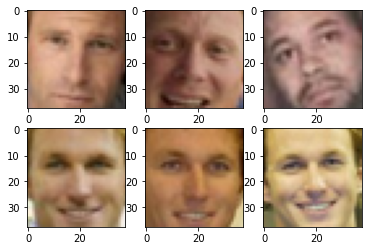

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [ ]:
class Reshape(nn.Module):
    """ this class corresponds to torch.reshape function and may be used as a reshape layer """
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [ ]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction) ** 2)
    

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.


In [ ]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [ ]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    #code = model.enc(img[None].cuda(device=device))
    code = model.enc(img[None])

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()


In [ ]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

370it [00:07, 51.56it/s]


1, Train loss: 0.10102635219401589, Test loss: 0.02360593848072803


370it [00:06, 54.75it/s]


2, Train loss: 0.023232997398292377, Test loss: 0.023311268029755344


370it [00:06, 55.68it/s]


3, Train loss: 0.02291331547506858, Test loss: 0.023009849058765425


370it [00:06, 55.50it/s]


4, Train loss: 0.02267334132476823, Test loss: 0.022805967953260835


370it [00:06, 55.97it/s]


5, Train loss: 0.022393620923206656, Test loss: 0.0227202967816506


370it [00:06, 54.08it/s]


6, Train loss: 0.021902853801453587, Test loss: 0.02168294330259181


370it [00:06, 54.15it/s]


7, Train loss: 0.020885475117740752, Test loss: 0.02035741153077415


370it [00:07, 50.72it/s]


8, Train loss: 0.019323775763783135, Test loss: 0.018606318878068545


370it [00:06, 54.20it/s]


9, Train loss: 0.017778466846772978, Test loss: 0.01730162382268397


370it [00:06, 54.44it/s]


10, Train loss: 0.016241089053530958, Test loss: 0.015312533037922989


370it [00:07, 52.85it/s]


11, Train loss: 0.014791994415920972, Test loss: 0.014199422328599146


370it [00:07, 50.46it/s]


12, Train loss: 0.013541048698853374, Test loss: 0.013597629426723924


370it [00:06, 56.68it/s]


13, Train loss: 0.012333481854548406, Test loss: 0.01222582436457991


370it [00:06, 55.18it/s]


14, Train loss: 0.01155846710617784, Test loss: 0.011305751043186305


370it [00:06, 53.52it/s]


15, Train loss: 0.010732574244025567, Test loss: 0.010454354254282133


370it [00:06, 54.73it/s]


16, Train loss: 0.010168210802753817, Test loss: 0.01017191498291031


370it [00:06, 53.52it/s]


17, Train loss: 0.009523355949514752, Test loss: 0.01011368587786296


370it [00:06, 53.51it/s]


18, Train loss: 0.009035478677998046, Test loss: 0.009331819206621888


370it [00:07, 46.77it/s]


19, Train loss: 0.00860468995619417, Test loss: 0.008329541879153936


370it [00:09, 39.60it/s]


20, Train loss: 0.008312982422826768, Test loss: 0.007957342729959389


370it [00:07, 50.97it/s]


21, Train loss: 0.008036970759664938, Test loss: 0.00843473436459606


370it [00:06, 55.18it/s]


22, Train loss: 0.007818261992917496, Test loss: 0.007659978268475299


370it [00:07, 52.23it/s]


23, Train loss: 0.007590762553461735, Test loss: 0.007741722022489812


370it [00:06, 55.62it/s]


24, Train loss: 0.007332167599523756, Test loss: 0.0073579863169089795


370it [00:06, 53.17it/s]


25, Train loss: 0.007176390152306472, Test loss: 0.007337648145406074


370it [00:06, 55.55it/s]


26, Train loss: 0.007103338983128651, Test loss: 0.006925606752843858


370it [00:06, 57.05it/s]


27, Train loss: 0.006968759566613416, Test loss: 0.006935225587960121


370it [00:06, 53.68it/s]


28, Train loss: 0.00680131006697088, Test loss: 0.006795842522000005


370it [00:06, 55.94it/s]


29, Train loss: 0.0066345527576002995, Test loss: 0.006912397724211178


370it [00:06, 55.32it/s]


30, Train loss: 0.006571715471580665, Test loss: 0.006583576362815639


370it [00:06, 53.47it/s]


31, Train loss: 0.006456389684625395, Test loss: 0.006318901887528337


370it [00:06, 55.30it/s]


32, Train loss: 0.006340379489829032, Test loss: 0.006675965524928382


370it [00:06, 55.86it/s]


33, Train loss: 0.006288168976987543, Test loss: 0.006652416196997819


370it [00:06, 55.00it/s]


34, Train loss: 0.006228640412943248, Test loss: 0.006381274496177697


370it [00:06, 55.93it/s]


35, Train loss: 0.006146291349141351, Test loss: 0.006121445857671828


370it [00:06, 54.00it/s]


36, Train loss: 0.006096563467348822, Test loss: 0.006058463083451893


370it [00:06, 56.69it/s]


37, Train loss: 0.006051872415583665, Test loss: 0.006151479803988182


370it [00:06, 53.82it/s]


38, Train loss: 0.006001881141344657, Test loss: 0.006997651078412356


370it [00:06, 53.63it/s]


39, Train loss: 0.005922072040543703, Test loss: 0.00606775776496337


370it [00:06, 55.53it/s]


40, Train loss: 0.005981508207671625, Test loss: 0.006294653928328655


In [ ]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

0.006273875123155052


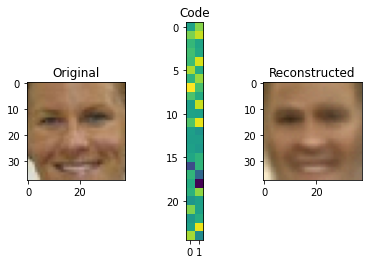

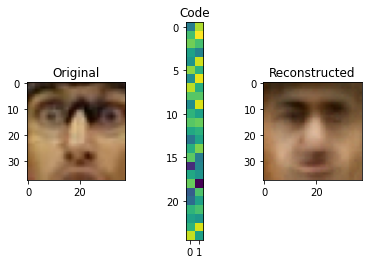

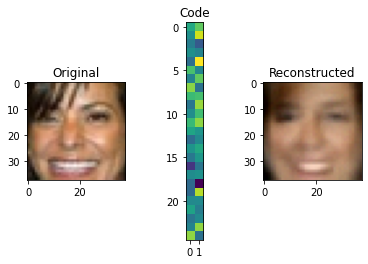

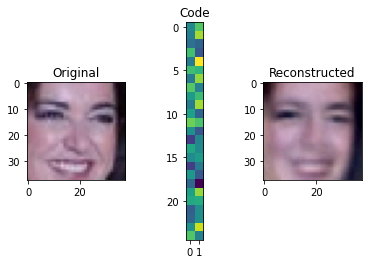

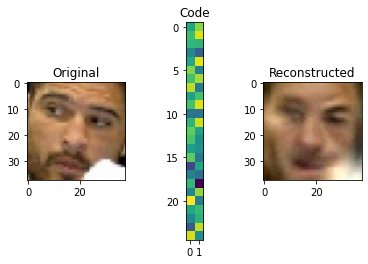

In [ ]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.


A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [ ]:
class DeepAutoencoder(nn.Module):
    def __init__(self, code_size=50):
        super(DeepAutoencoder, self).__init__()
        #self.enc = #<Your code: define encoder as per instructions above>
        #self.dec = #<Your code: define decoder as per instructions above>

        self.enc = nn.Sequential(
            Reshape(-1, np.prod(img_shape)), 
            nn.Linear(np.prod(img_shape), code_size * 5), 
            nn.ReLU(), 
            nn.Linear(code_size * 5, code_size * 3),
            nn.ReLU(), 
            nn.Linear(code_size * 3, code_size))
        
        self.dec = nn.Sequential(
            nn.Linear(code_size, code_size * 3),
            nn.ReLU(),
            nn.Linear(code_size * 3, code_size * 5),
            nn.ReLU(),
            nn.Linear(code_size * 5, np.prod(img_shape)), 
            Reshape(-1, img_shape[0], img_shape[1], img_shape[2]))  
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [ ]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction) ** 2)

In [ ]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = DeepAutoencoder(code_size).float().to(device)
    #encoder_out = model.enc(help_tensor.cuda(device))
    encoder_out = model.enc(help_tensor.to(torch.float32))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:] == img_shape,   "decoder must output an image of valid shape"

    assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


In [ ]:
aenc_deep = DeepAutoencoder()
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=50)

370it [00:22, 16.24it/s]


1, Train loss: 0.021838295587979038, Test loss: 0.015460313306239344


370it [00:25, 14.38it/s]


2, Train loss: 0.013217867909944121, Test loss: 0.012376371126051222


370it [00:25, 14.72it/s]


3, Train loss: 0.011599561670904144, Test loss: 0.01108904324174402


370it [00:22, 16.42it/s]


4, Train loss: 0.01038986968169007, Test loss: 0.010273184943971272


370it [00:22, 16.36it/s]


5, Train loss: 0.009700698997574548, Test loss: 0.009501178312386798


370it [00:22, 16.29it/s]


6, Train loss: 0.009030975343186934, Test loss: 0.009110115919085237


370it [00:22, 16.17it/s]


7, Train loss: 0.008672201681724712, Test loss: 0.008651386781763767


370it [00:22, 16.26it/s]


8, Train loss: 0.008371641132283327, Test loss: 0.008321808177272351


370it [00:22, 16.09it/s]


9, Train loss: 0.008051444135749857, Test loss: 0.008137246387519666


370it [00:22, 16.35it/s]


10, Train loss: 0.0077393675948907335, Test loss: 0.007805123848604463


370it [00:22, 16.16it/s]


11, Train loss: 0.007532822646090728, Test loss: 0.007655711274899196


370it [00:22, 16.19it/s]


12, Train loss: 0.007281842153320096, Test loss: 0.007361834170111577


370it [00:22, 16.29it/s]


13, Train loss: 0.007099651467669037, Test loss: 0.007185266805187525


370it [00:22, 16.30it/s]


14, Train loss: 0.0069876637368021105, Test loss: 0.007073216480942668


370it [00:22, 16.29it/s]


15, Train loss: 0.006894883116607185, Test loss: 0.006982732460983175


370it [00:23, 15.89it/s]


16, Train loss: 0.006812367283123755, Test loss: 0.006951094571740131


370it [00:24, 15.07it/s]


17, Train loss: 0.006686878317419882, Test loss: 0.006833578968409932


370it [00:27, 13.57it/s]


18, Train loss: 0.006645593595370224, Test loss: 0.006784359928957535


370it [00:36, 10.07it/s]


19, Train loss: 0.006535972574186575, Test loss: 0.006729584272730333


370it [00:32, 11.45it/s]


20, Train loss: 0.006472393034773567, Test loss: 0.006498191807474772


370it [00:32, 11.45it/s]


21, Train loss: 0.006381045040229353, Test loss: 0.006651304701128703


370it [00:31, 11.58it/s]


22, Train loss: 0.00627764055323442, Test loss: 0.006516569278131547


370it [00:32, 11.31it/s]


23, Train loss: 0.006238757476574589, Test loss: 0.006516115583456941


370it [00:33, 11.21it/s]


24, Train loss: 0.006146293829690752, Test loss: 0.006212296727943065


370it [00:33, 11.01it/s]


25, Train loss: 0.006095641255288383, Test loss: 0.006234160695358771


370it [00:34, 10.76it/s]


26, Train loss: 0.0060216686672617545, Test loss: 0.006193817713769953


370it [00:36, 10.11it/s]


27, Train loss: 0.0059499350814355735, Test loss: 0.006040536016235114


370it [00:34, 10.85it/s]


28, Train loss: 0.005864078802586241, Test loss: 0.006054856300429429


370it [00:33, 11.06it/s]


29, Train loss: 0.005810789214300555, Test loss: 0.006092684513726152


370it [00:34, 10.69it/s]


30, Train loss: 0.005747014098360279, Test loss: 0.0061043635213515295


370it [00:34, 10.59it/s]


31, Train loss: 0.0056811233520614075, Test loss: 0.0059547714988599666


370it [00:34, 10.63it/s]


32, Train loss: 0.005646614266975451, Test loss: 0.0057833517209928504


370it [00:34, 10.71it/s]


33, Train loss: 0.00558586954831661, Test loss: 0.00609610825620892


370it [00:36, 10.18it/s]


34, Train loss: 0.0055759678103196215, Test loss: 0.005835742564702867


370it [00:35, 10.40it/s]


35, Train loss: 0.005519955644583478, Test loss: 0.005738807801319525


370it [00:34, 10.82it/s]


36, Train loss: 0.005481283293581515, Test loss: 0.005718062894359019


370it [00:34, 10.61it/s]


37, Train loss: 0.005431942937761726, Test loss: 0.005647255342079891


370it [00:34, 10.84it/s]


38, Train loss: 0.005411054464427065, Test loss: 0.005679019342275234


370it [00:34, 10.64it/s]


39, Train loss: 0.005366188728558758, Test loss: 0.005543640373609954


370it [00:34, 10.67it/s]


40, Train loss: 0.005358030219371838, Test loss: 0.005522987183445438


370it [00:36, 10.15it/s]


41, Train loss: 0.0053233120028412925, Test loss: 0.0056017913406053044


370it [00:35, 10.54it/s]


42, Train loss: 0.00529180998529856, Test loss: 0.005575815979315835


370it [00:34, 10.60it/s]


43, Train loss: 0.005271922611865929, Test loss: 0.005583954530347246


370it [00:35, 10.48it/s]


44, Train loss: 0.005221191145659413, Test loss: 0.005482009566152592


370it [00:35, 10.32it/s]


45, Train loss: 0.005219421809490519, Test loss: 0.005476035400019929


370it [00:36, 10.24it/s]


46, Train loss: 0.005185949437634006, Test loss: 0.005458665744551541


370it [00:36, 10.13it/s]


47, Train loss: 0.0051691109938062745, Test loss: 0.005419172651358459


370it [00:35, 10.44it/s]


48, Train loss: 0.005136852508753332, Test loss: 0.00554955202552075


370it [00:35, 10.42it/s]


49, Train loss: 0.005106560571879825, Test loss: 0.005342960867297988


370it [00:34, 10.67it/s]


50, Train loss: 0.005073070077052075, Test loss: 0.005404448539982055


Training may take long, it's okay.

Final MSE: 0.005308017738041309


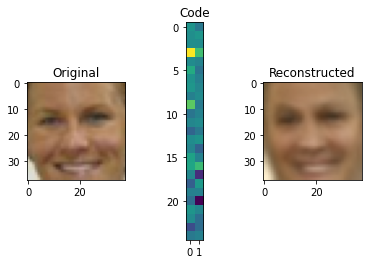

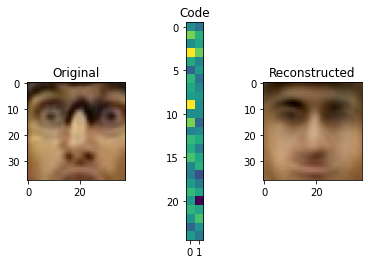

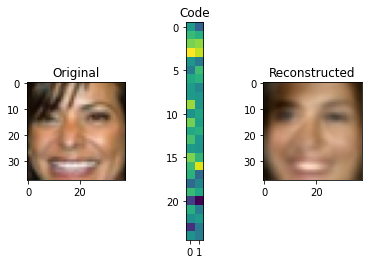

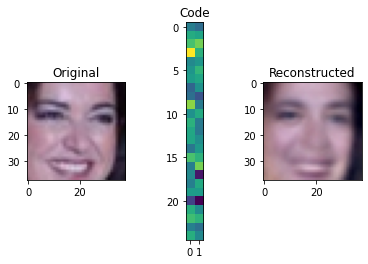

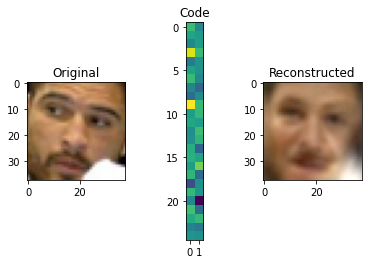

In [ ]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)

assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 50, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 50 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [ ]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    noise = np.random.normal(size=X.shape, scale=sigma)
        
    return X + noise
    

In [ ]:
#noise tests
theoretical_std = (X[:100].std() ** 2 + 0.5 ** 2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

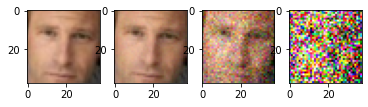

In [ ]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [ ]:
aenc = DeepAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

370it [00:27, 13.58it/s]


1, Train loss: 0.0221987950753074, Test loss: 0.01495817531631304


370it [00:32, 11.34it/s]


2, Train loss: 0.01339532608632413, Test loss: 0.012976099721813402


370it [00:28, 13.13it/s]


3, Train loss: 0.011641359054902397, Test loss: 0.010865904948519198


370it [00:28, 13.01it/s]


4, Train loss: 0.01047682969040537, Test loss: 0.010364802211084375


370it [00:28, 13.08it/s]


5, Train loss: 0.009828524169960755, Test loss: 0.009671839362016979


370it [00:29, 12.68it/s]


6, Train loss: 0.009211724701189925, Test loss: 0.009145827510541073


370it [00:28, 12.88it/s]


7, Train loss: 0.008749407462848677, Test loss: 0.008791906471174097


370it [00:28, 13.04it/s]


8, Train loss: 0.008416365232490754, Test loss: 0.008360205010621846


370it [00:28, 12.96it/s]


9, Train loss: 0.008133419022886588, Test loss: 0.008054607263501753


370it [00:28, 12.98it/s]


10, Train loss: 0.007865378484523245, Test loss: 0.008297207964974736


370it [00:28, 13.01it/s]


11, Train loss: 0.0076720892986335614, Test loss: 0.007667956303721591


370it [00:28, 13.11it/s]


12, Train loss: 0.0075204473772604325, Test loss: 0.007472604214975847


370it [00:28, 12.84it/s]


13, Train loss: 0.007326534300559096, Test loss: 0.007293006213362424


370it [00:27, 13.22it/s]


14, Train loss: 0.007213647770183762, Test loss: 0.007297993797601507


370it [00:28, 13.19it/s]


15, Train loss: 0.007053177145632767, Test loss: 0.007034669064407998


370it [00:28, 13.00it/s]


16, Train loss: 0.006904428095936845, Test loss: 0.007035242380549896


370it [00:28, 13.07it/s]


17, Train loss: 0.006796126592685211, Test loss: 0.0068905126810288


370it [00:33, 11.11it/s]


18, Train loss: 0.00668710646863776, Test loss: 0.006713604200173461


370it [00:42,  8.78it/s]


19, Train loss: 0.006595597170750965, Test loss: 0.0066983349980264326


370it [00:39,  9.34it/s]


20, Train loss: 0.006565902264028762, Test loss: 0.006680229552254176


370it [00:39,  9.43it/s]


21, Train loss: 0.006524786412535745, Test loss: 0.006615152294481957


370it [00:39,  9.46it/s]


22, Train loss: 0.006494926683214293, Test loss: 0.006571397610601914


370it [00:39,  9.42it/s]


23, Train loss: 0.006456159738950531, Test loss: 0.006523211224491891


370it [00:39,  9.43it/s]


24, Train loss: 0.006391009463585153, Test loss: 0.00650233039812622


370it [00:39,  9.26it/s]


25, Train loss: 0.006332612468503554, Test loss: 0.006388662230786665


370it [00:39,  9.39it/s]


26, Train loss: 0.006253519469302942, Test loss: 0.0066368463445313245


370it [00:40,  9.21it/s]


27, Train loss: 0.006168315743424768, Test loss: 0.006260887052027807


370it [00:40,  9.20it/s]


28, Train loss: 0.006098334104782787, Test loss: 0.006088378156172751


370it [00:40,  9.25it/s]


29, Train loss: 0.0060382316337743965, Test loss: 0.006307829576524785


370it [00:39,  9.28it/s]


30, Train loss: 0.0059455533665626675, Test loss: 0.006126000906949982


370it [00:41,  8.96it/s]


31, Train loss: 0.005898574424775066, Test loss: 0.005977710387022066


370it [00:41,  8.99it/s]


32, Train loss: 0.00589053562005394, Test loss: 0.0060039367374302224


370it [00:40,  9.05it/s]


33, Train loss: 0.005853650965559398, Test loss: 0.005935382728432813


352it [00:39,  9.20it/s]

Final MSE: 0.005723841141131219


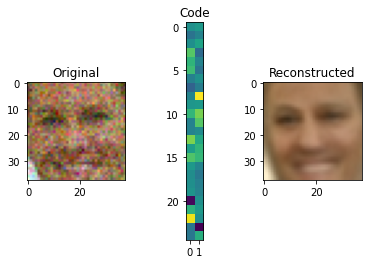

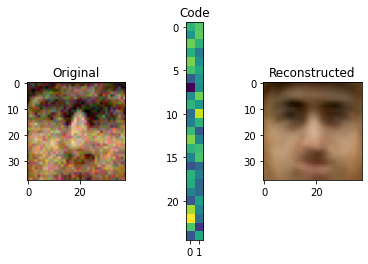

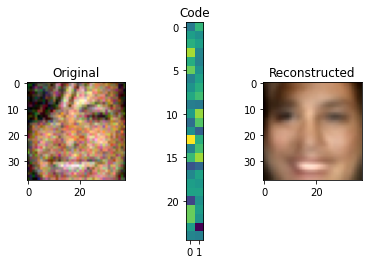

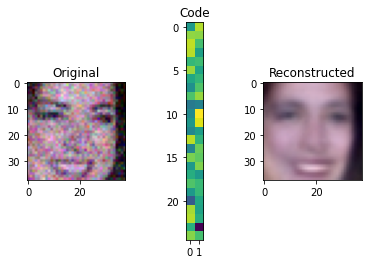

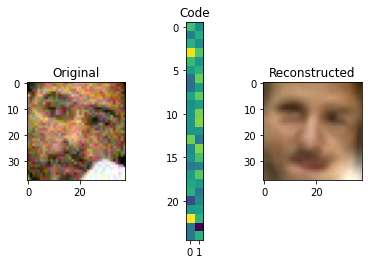

In [ ]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    #scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    scores.append(aenc.batch_loss(batch_noised, batch).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [ ]:
#encodes batch of images into a codes


codes = aenc.enc(X_train_tensor)


In [ ]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [ ]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes.detach().cpu().numpy())

In [ ]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch, 3, height, width]"

    code = aenc.enc(image.cuda(device)).detach().cpu().numpy()
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [ ]:
def show_similar(image):
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

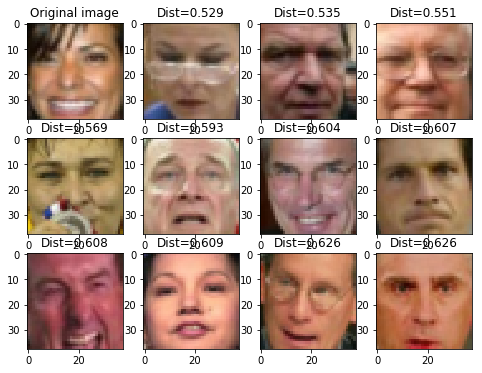

In [ ]:
#smiles
show_similar(X_test_tensor[2])

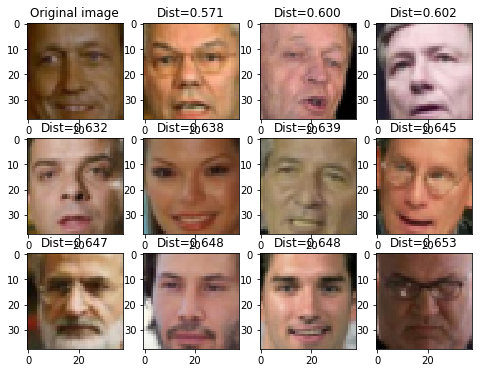

In [ ]:
#ethnicity
show_similar(X_test_tensor[500])

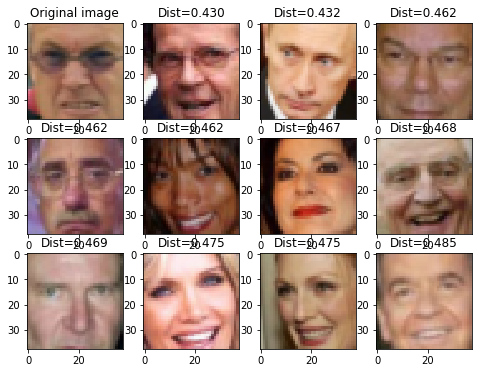

In [ ]:
#glasses
show_similar(X_test_tensor[66])

## Bonus: cheap image morphing


torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


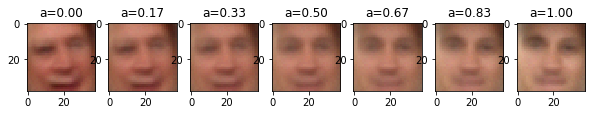

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


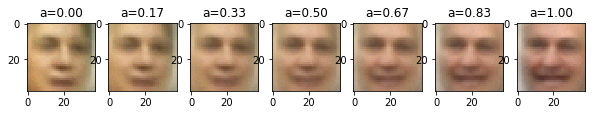

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


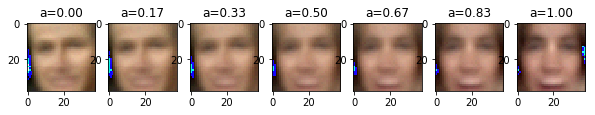

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


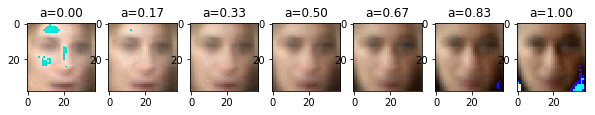

torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])
torch.Size([38, 38, 3])


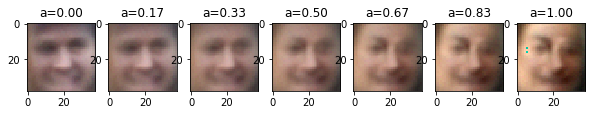

In [ ]:

for _ in range(5):
    image1,image2 = X_test_tensor[np.random.randint(0,len(X_test),size=2)]

    image_pair = torch.cat((image1,image2), 0).cuda(device)
    # ^-- note: depending on your implementation, you may need to call torch.permute here
    
    
    code1, code2 = aenc.enc(image_pair)

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy())
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.
If you want to generate images from scratch, however, you're better off using generative adversarial networks.